In [73]:
# predict the next rssi value from current time value
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import glob
import os
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline

In [74]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    for _ in range(size_of_mini_batch):
        d = random.choice(train_data)
        inputs  = np.append(inputs, d)
    inputs  = inputs.reshape(-1, length_of_sequences)
    return inputs

In [75]:
# test code
data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)
np.shape(data)

(10, 10)

In [76]:
a = [1,2,3]
b = [a for i in range(3)]
ba = np.array(b)
ba.reshape(-1, 3, 1)

array([[[1],
        [2],
        [3]],

       [[1],
        [2],
        [3]],

       [[1],
        [2],
        [3]]])

In [182]:
#''' pred area judgement from rssi
data_path                   = "./input/data.csv"
test_data_path              = './input/test.csv'
num_of_sequence_length      = 10
num_of_hidden_nodes         = 20
num_of_training_epochs      = 100
size_of_mini_batch          = 10
size_of_test_batch          = 4
learning_rate               = 0.02
train_dir                   = 'train'

In [222]:
data = np.loadtxt(train_data_path, delimiter=",", skiprows=1, dtype=np.float32)
#train_data
#train_data = data[[np.where((data[:, 0] == 2) & (data[:, 1] == 1))],3:].reshape(-1, num_of_sequence_length)
train_data = data[[np.where((data[:, 1] == 1))],3:].reshape(-1, num_of_sequence_length)
print(train_data)
test_data = data[[np.where((data[:, 0] == 2) & (data[:, 1] == 0) & (data[:, 2] == 0))],3:].reshape(-1, num_of_sequence_length)
print(test_data)
train_data *= -0.01
test_data *= -0.01

[[-50. -50. -50. -51. -49. -47. -45. -44. -45. -49.]
 [-53. -53. -53. -53. -51. -50. -50. -51. -52. -52.]
 [-54. -54. -54. -53. -52. -50. -48. -48. -47. -46.]
 [-49. -47. -46. -45. -44. -44. -42. -41. -41. -41.]
 [-51. -49. -47. -46. -44. -43. -43. -46. -51. -53.]
 [-51. -52. -52. -51. -49. -49. -51. -50. -48. -49.]
 [-47. -44. -42. -39. -38. -38. -38. -37. -38. -38.]
 [-49. -46. -44. -41. -39. -39. -39. -40. -43. -46.]
 [-57. -56. -54. -51. -48. -48. -49. -51. -53. -52.]
 [-56. -58. -60. -60. -58. -55. -55. -54. -53. -52.]
 [-58. -56. -54. -53. -53. -53. -50. -48. -48. -49.]
 [-53. -54. -55. -53. -51. -49. -50. -48. -45. -46.]
 [-55. -52. -50. -51. -48. -44. -43. -44. -45. -46.]
 [-58. -60. -61. -59. -56. -55. -56. -54. -50. -52.]
 [-60. -57. -56. -58. -60. -57. -52. -49. -48. -48.]
 [-56. -53. -51. -52. -53. -52. -48. -45. -42. -43.]
 [-57. -57. -54. -52. -53. -54. -51. -48. -47. -46.]
 [-58. -55. -52. -52. -54. -54. -52. -49. -48. -47.]
 [-48. -48. -49. -49. -50. -48. -46. -44. -42.

In [223]:
# random seed fix
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

In [225]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.Graph().as_default():
    input_ph      = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="supervisor")
    batch_size_ph = tf.placeholder(tf.int32, name="batch_size")

    with tf.name_scope("inference") as scope:
        weight_var = tf.Variable(tf.truncated_normal([num_of_sequence_length, num_of_hidden_nodes], stddev=0.1), name="weight")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_sequence_length], stddev=0.1), name="bias2")

        weight_hist = tf.histogram_summary("layer/weights", weight_var)
        bias1_hist = tf.histogram_summary("layer/biases1", bias1_var)
        bias2_hist = tf.histogram_summary("layer/biases2", bias2_var)

        hidden = tf.sigmoid(tf.matmul(input_ph, weight_var) + bias1_var)
        output_op = tf.sigmoid(tf.matmul(hidden, tf.transpose(weight_var) + bias2_var))

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error
        tf.scalar_summary("loss", loss_op)

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

#    with tf.name_scope("test") as scope:
#        judge = tf.select(tf.greater(output_op, 0.5), tf.zeros_like(output_op, dtype=tf.float32), tf.ones_like(output_op, dtype=tf.float32))
#        valid = tf.select(tf.equal(judge, supervisor_ph), tf.zeros_like(judge, dtype=tf.float32), tf.ones_like(judge, dtype=tf.float32))
#        accuracy_op = tf.reduce_mean(valid)

    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        summary_writer = tf.train.SummaryWriter("train", graph=sess.graph)
        sess.run(init)
        accuracy_results = []
        
        for epoch in range(num_of_training_epochs):
            data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)

            train_dict = {
                input_ph:      data,
                supervisor_ph: data,
                batch_size_ph: size_of_mini_batch,
            }
            sess.run(training_op, feed_dict=train_dict)

            if (epoch + 1) % 2 == 0:
                summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
                summary_writer.add_summary(summary_str, epoch)
                
                # eval accuracy
#                data = make_mini_batch(train_data, size_of_test_batch, num_of_sequence_length)
                data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)
                pred_dict = {
                    input_ph:      data,
                    supervisor_ph: data,
                    batch_size_ph: size_of_test_batch,
                }
                accuracy_results.append([epoch, train_loss])
                preddata = sess.run(output_op, feed_dict=pred_dict)
                print("train#%d, train loss: %e" % (epoch + 1, train_loss))
#                print(' data: {0}'.format(data[0]))
#                print(' pred: {0}'.format(preddata[0]))
                
#        saver.save(sess, os.path.join(train_dir, "model.ckpt"), num_of_training_epochs)
#        projector.visualize_embeddings(summary_writer, config)

        for epoch in range(len(train_data)):
            data = train_data[epoch].reshape(-1, num_of_sequence_length)

            train_dict = {
                input_ph:      data,
                supervisor_ph: data,
                batch_size_ph: 1,
            }

            summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
            summary_writer.add_summary(summary_str, epoch)
            print('test w/ train #.%d %f' % (epoch, train_loss))

        for epoch in range(len(test_data)):
            data = test_data[epoch].reshape(-1, num_of_sequence_length)

            train_dict = {
                input_ph:      data,
                supervisor_ph: data,
                batch_size_ph: 1,
            }

            summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
            summary_writer.add_summary(summary_str, epoch)
            print('test w/ test  #.%d %f' % (epoch, train_loss))

#            train_data[k] = np.c_[d, [0 for x in range(length_of_sequences)] + pred_bool_n]
                
#        saver.save(sess, "data/model")



train#2, train loss: 5.312449e-03
train#4, train loss: 4.865183e-03
train#6, train loss: 8.793581e-03
train#8, train loss: 6.290817e-03
train#10, train loss: 2.670664e-03
train#12, train loss: 3.522317e-03
train#14, train loss: 5.556117e-03
train#16, train loss: 3.392872e-03
train#18, train loss: 4.509054e-03
train#20, train loss: 3.364481e-03
train#22, train loss: 3.457183e-03
train#24, train loss: 4.607446e-03
train#26, train loss: 3.864083e-03
train#28, train loss: 1.260949e-03
train#30, train loss: 2.044947e-03
train#32, train loss: 1.625187e-03
train#34, train loss: 2.825179e-03
train#36, train loss: 2.455062e-03
train#38, train loss: 3.685089e-03
train#40, train loss: 3.239475e-03
train#42, train loss: 1.377417e-03
train#44, train loss: 1.334283e-03
train#46, train loss: 2.190358e-03
train#48, train loss: 2.432199e-03
train#50, train loss: 3.110403e-03
train#52, train loss: 2.206546e-03
train#54, train loss: 2.532295e-03
train#56, train loss: 3.400501e-03
train#58, train loss: 3.

In [155]:
len(train_data)

8

In [103]:
"{0:04d}".format(5.2)

ValueError: Unknown format code 'd' for object of type 'float'

,epoch,train_loss
0,1,0.005312
1,3,0.004865
2,5,0.008794
3,7,0.006291
4,9,0.002671


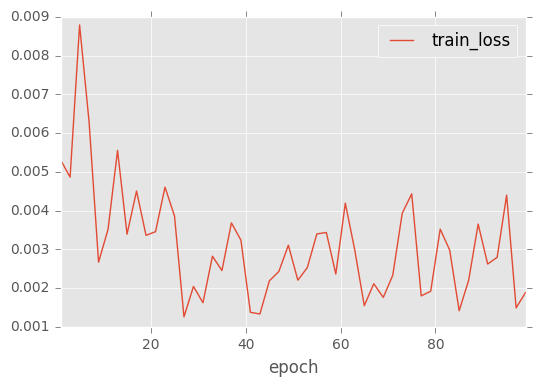

In [228]:
## result graph　
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
matplotlib.rc('font', **font)

#accuracy = [0.810000, 0.720000, 0.920000, 0.800000, 0.730000, 0.790000, 0.750000, 0.700000, 0.770000, 0.720000, 0.740000, 0.930000, 0.940000, 0.810000, 0.850000, 0.960000, 0.940000, 0.800000, 0.750000, 0.920000, 0.960000, 0.960000, 0.890000, 0.950000, 0.950000, 0.940000, 0.970000, 0.900000, 0.990000, 0.950000, 0.960000, 0.990000, 0.960000, 0.940000, 0.950000, 0.980000, 0.950000, 0.960000, 0.980000, 0.980000, 0.910000, 0.930000, 0.970000, 0.960000, 0.960000, 0.940000, 0.970000, 0.950000, 0.980000, 0.970000, 0.930000, 0.970000, 0.980000, 0.900000, 0.970000, 0.970000, 0.940000, 0.990000, 0.990000, 0.980000, 0.960000, 0.980000, 0.990000, 0.990000, 0.980000, 0.980000, 0.850000, 0.900000, 0.910000, 0.980000, 0.970000, 0.960000, 0.980000, 0.980000, 0.990000, 0.950000, 0.970000, 0.970000, 0.980000, 0.960000, 0.980000, 0.980000, 0.990000, 0.940000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 1.000000, 0.930000, 0.990000, 0.960000, 0.980000, 0.990000, 0.940000, 0.950000, 0.980000, 0.990000, 1.000000, 0.980000, 0.990000, 0.970000, 1.000000, 0.980000, 0.990000, 0.970000, 0.980000, 0.970000, 1.000000, 0.980000, 0.940000, 0.950000, 0.980000, 0.980000, 0.990000, 0.990000, 0.980000, 0.990000, 0.980000, 0.970000, 0.980000, 0.980000, 0.990000, 0.980000, 1.000000, 0.980000, 0.970000, 0.970000, 1.000000, 0.990000, 0.970000, 0.990000, 0.970000, 0.970000, 0.970000, 0.850000, 0.980000, 0.990000, 1.000000, 0.960000, 0.990000, 0.980000, 1.000000, 0.980000, 1.000000, 1.000000, 0.930000, 0.940000, 0.900000, 0.950000, 0.780000, 0.920000, 0.930000, 1.000000, 0.930000, 0.990000, 1.000000, 0.990000, 0.950000, 0.980000, 0.980000, 0.930000, 0.910000, 0.970000, 0.920000, 0.950000, 0.930000, 0.950000, 0.970000, 0.980000, 0.970000, 0.970000, 0.960000, 0.970000, 0.930000, 0.970000, 0.990000, 0.970000, 0.990000, 0.980000, 0.980000, 0.980000, 0.980000, 0.960000, 0.970000, 0.990000, 0.990000, 0.980000, 0.970000, 0.970000, 0.970000, 0.980000, 0.970000, 0.990000, 0.950000, 0.990000, 0.990000, 0.950000, 0.990000, 0.960000, 0.980000, 0.990000, 0.950000, 1.000000, 0.970000, 0.960000, 0.990000, 0.980000, 0.990000, 1.000000, 0.970000, 1.000000, 0.980000, 1.000000, 0.960000, 0.970000, 0.980000, 0.980000, 0.980000, 0.970000, 1.000000, 0.990000, 0.990000, 0.990000, 1.000000, 0.990000, 0.980000, 1.000000, 1.000000, 0.900000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.970000, 0.960000, 0.980000, 1.000000, 0.980000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 0.980000, 0.990000, 0.980000, 0.940000, 0.980000, 1.000000, 0.970000, 1.000000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 0.990000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.990000, 0.970000, 0.970000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.970000, 0.970000, 0.990000, 1.000000, 0.970000, 0.980000, 0.990000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.980000, 0.970000, 0.980000, 0.990000, 1.000000, 1.000000, 0.950000, 0.980000, 0.970000, 1.000000, 0.920000, 0.960000, 0.960000, 0.950000, 0.970000, 0.970000, 0.990000, 0.990000, 0.990000, 0.940000, 0.930000, 0.960000, 0.970000, 0.900000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 0.980000, 1.000000, 0.970000, 0.970000, 0.980000, 0.950000, 0.960000, 0.980000, 1.000000, 0.990000, 0.980000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.980000, 0.980000, 1.000000, 0.970000, 0.950000, 0.990000, 0.930000, 1.000000, 0.990000, 1.000000, 1.000000, 0.990000, 1.000000, 0.990000, 0.980000, 1.000000, 0.960000, 0.990000, 0.990000, 0.990000, 1.000000, 1.000000, 0.970000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 0.970000, 0.960000, 1.000000, 0.970000, 0.990000, 1.000000, 0.980000, 0.960000, 0.980000, 0.970000, 0.980000, 0.990000, 0.990000, 0.980000, 1.000000, 0.990000, 0.980000, 0.990000, 0.990000, 0.970000, 0.990000, 0.980000, 0.980000, 1.000000, 0.990000, 0.990000, 0.980000, 0.980000, 0.990000, 1.000000, 0.990000, 1.000000, 0.970000, 1.000000, 0.970000, 0.990000, 0.960000, 0.940000, 1.000000, 0.960000, 0.990000, 0.990000, 0.980000, 0.930000, 0.960000, 0.980000, 0.980000, 0.970000, 1.000000, 0.980000, 0.980000, 0.990000, 0.980000, 0.980000, 0.970000, 0.990000, 1.000000, 0.980000, 0.990000, 0.980000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 0.970000, 1.000000, 0.980000, 0.990000, 0.980000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 0.990000, 1.000000, 0.990000, 0.990000, 1.000000, 0.970000, 0.990000, 1.000000, 0.990000, 1.000000, 0.980000, 0.990000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 0.990000, 1.000000, 0.990000, 0.990000, 0.990000, 0.990000, 1.000000, 0.970000, 0.980000, 0.950000, 1.000000, 0.980000, 0.990000, 0.990000, 1.000000, 0.980000, 1.000000]
df = pd.DataFrame({
        'epoch': [x[0] for x in accuracy_results],
        'train_loss': [x[1] for x in accuracy_results]
    })
#        'epoch': range(10, 5010, 10)})
df.plot(x='epoch', y='train_loss')
df.head()

./input/20160907_05_gaze_kawachi.csv
./input/20160907_07_gaze_kawachi.csv
./input/20160907_04_gaze_kawachi.csv
./input/20160907_06_gaze_kawachi.csv
./input/20160907_09_gaze_kawachi.csv
./input/20160907_01_gaze_kawachi.csv
./input/20160907_08_gaze_kawachi.csv
./input/20160907_10_gaze_kawachi.csv
./input/20160907_02_gaze_kawachi.csv
./input/20160907_03_gaze_kawachi.csv


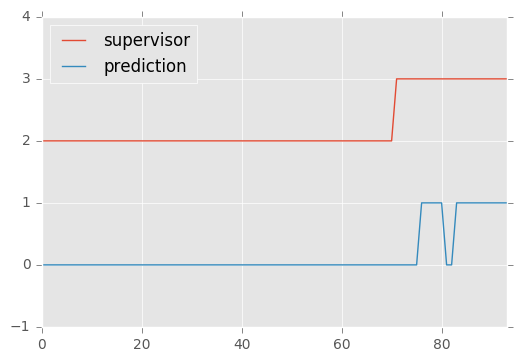

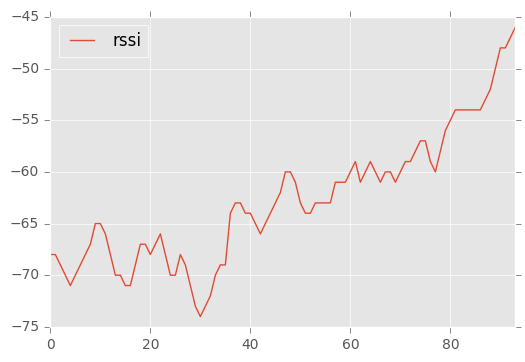

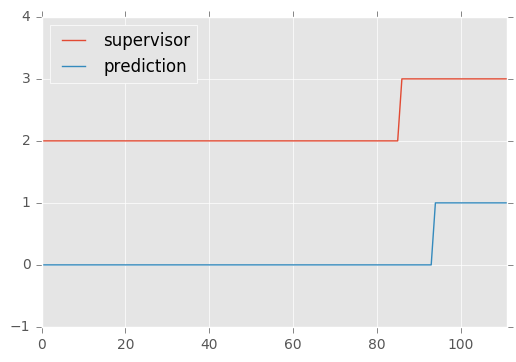

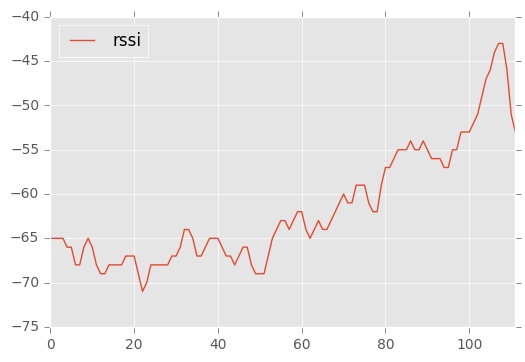

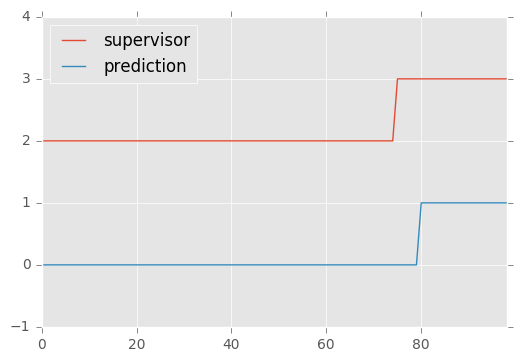

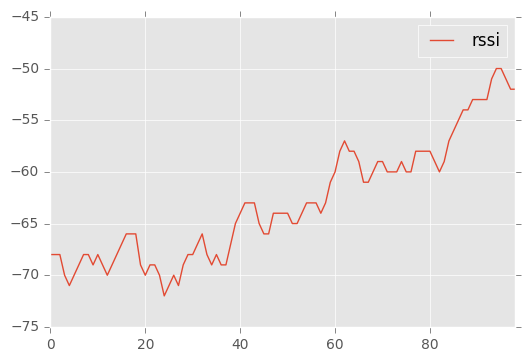

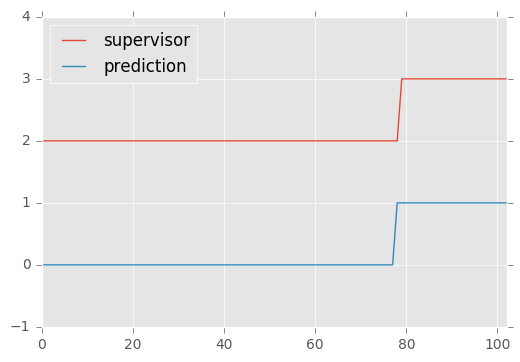

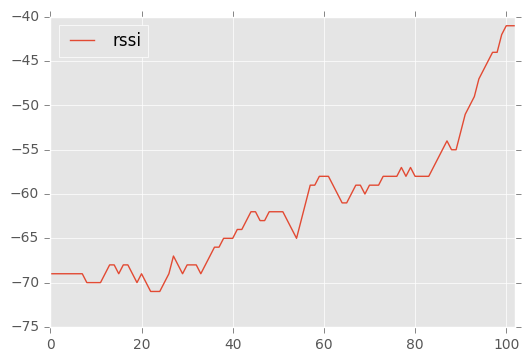

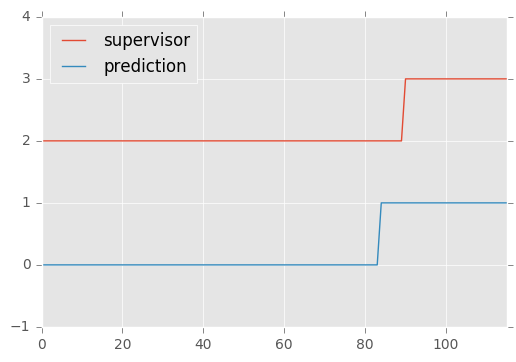

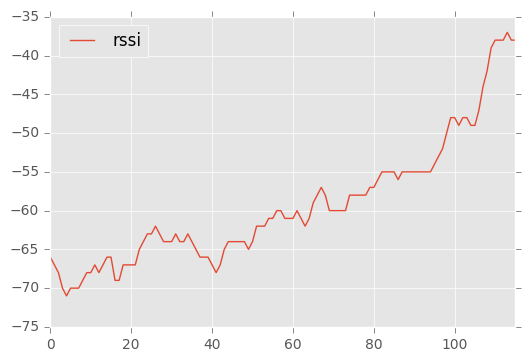

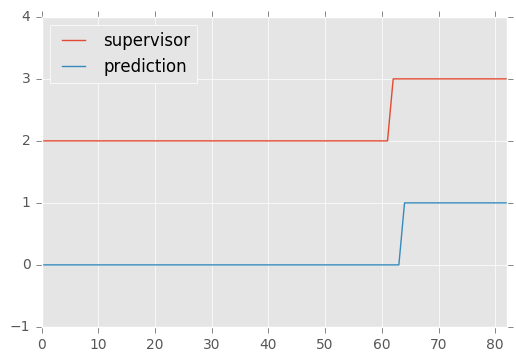

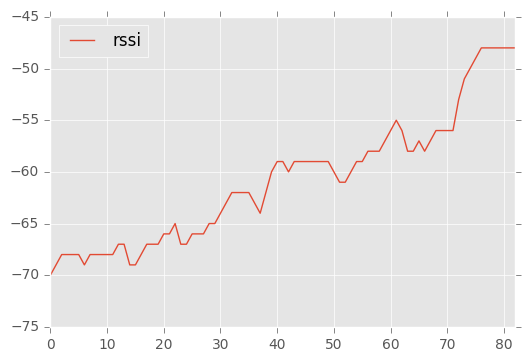

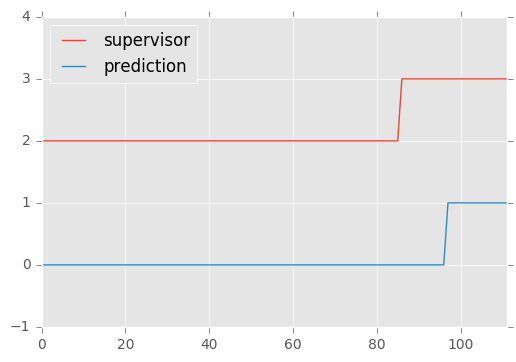

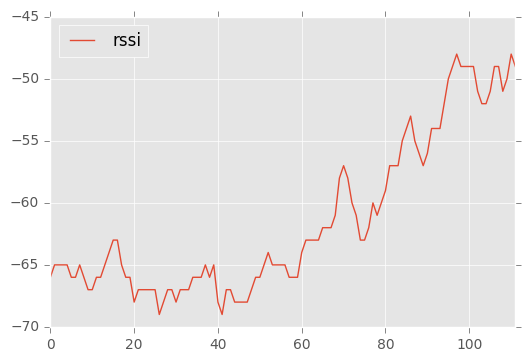

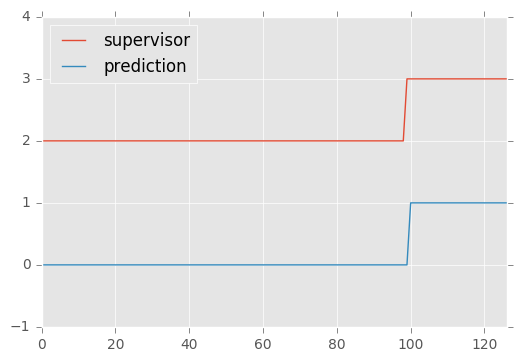

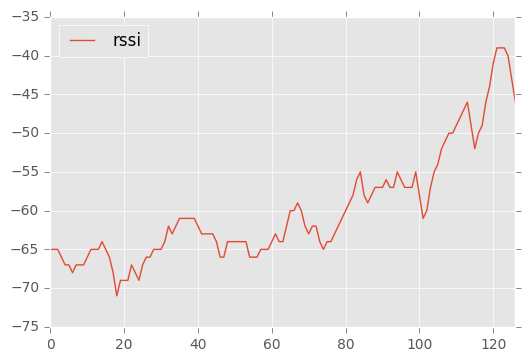

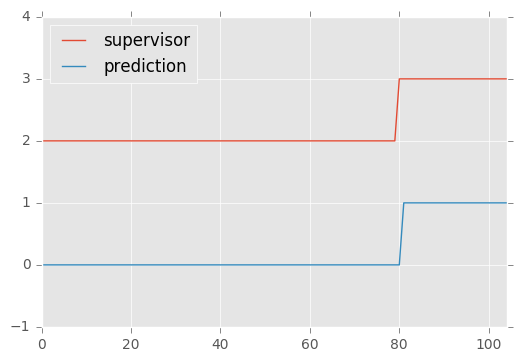

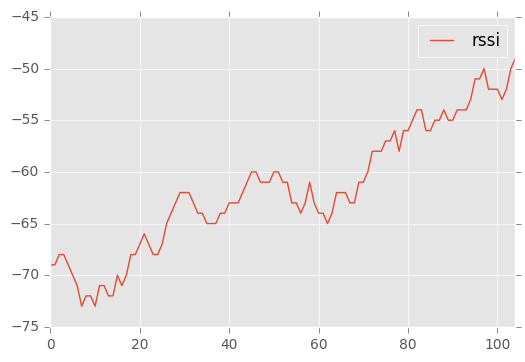

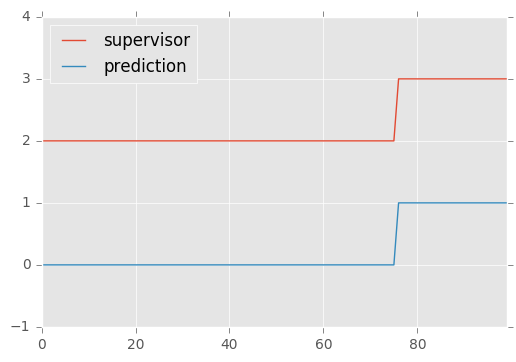

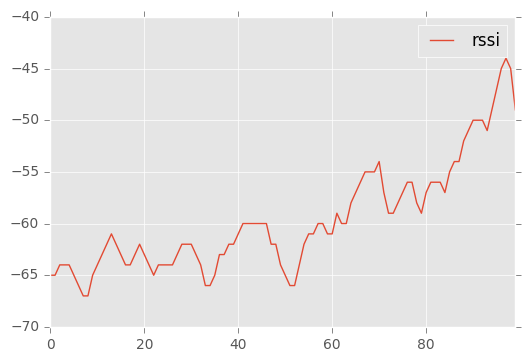

In [34]:
def plot_result(rssi, data, pred):
    prediction = pred
    supervisor = data
    df1 = pd.DataFrame({'rssi': rssi,
                        'supervisor': supervisor + 2,
                        'prediction': prediction})
    df1[['supervisor', 'prediction']].plot(ylim=[-1,4])
    df1[['rssi']].plot()

for k, d in train_data.items():
    print(k)
    pred = train_data[k][length_of_initial_sequences:,3]
    rssi = train_data[k][length_of_initial_sequences:,0] * 30 - 60
    data = train_data[k][length_of_initial_sequences:,2]
    plot_result(rssi, data, pred)

In [17]:
#train_data[random.choice(train_data.keys())]
random.choice(list(train_data.keys()))


'./input/20160907_01_gaze_kawachi.csv'

In [111]:
a = np.array([[1, 10], [1,11], [1,12], [2,20], [2,21], [2,22], [3,30], [3,31], [3,32]])
#np.where(a == 1)
a[[np.where(a[:, 0] == 1)],1].reshape(-1)

array([10, 11, 12])